### Generative Adversarial Networks  
Jay Urbain, Phd

Credits:  
- https://github.com/eriklindernoren/Keras-GAN  
- The network architecture has been found by, and optimized by, many contributors, including the authors of the DCGAN paper and people like Erik Linder-Norén, who’s excellent collection of GAN implementations called Keras GAN served as the basis of the code used here.

In [1]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!mkdir '/content/gdrive/My Drive/Colab Notebooks/dcgan_cifar_images'

In [0]:
dcgan_cifar_images = '/content/gdrive/My Drive/Colab Notebooks/dcgan_cifar_images'

#### The CIFAR-10 dataset   
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.   

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.  

Here are the classes in the dataset, as well as 10 random images from each:  

airplane  										
automobile  										
bird  										
cat  										
deer  										
dog   										
frog  										
horse  										
ship  										
truck  

170500096/170498071 [==============================] - 25s 0us/step


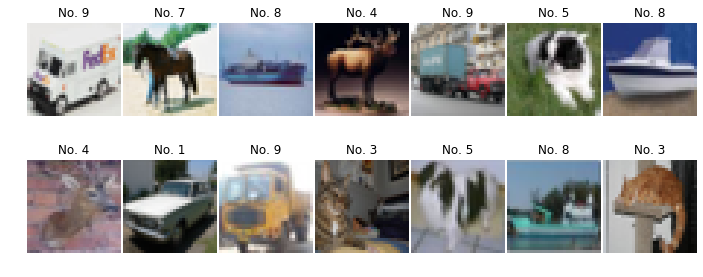

In [5]:
from keras.datasets.cifar10 import load_data

# load the data - it returns 2 tuples of digits & labels - one for
# the train set & the other for the test set
(train_digits, train_labels), (test_digits, test_labels) = cifar10.load_data()

# display 14 random images from the training set
import numpy as np
np.random.seed(123)

rand_14 = np.random.randint(0, train_digits.shape[0],14)
sample_digits = train_digits[rand_14]
sample_labels = train_labels[rand_14]
# code to view the images
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_digits[image_index], cmap='gray')
        ax[r,c].set_title('No. %d' % sample_labels[image_index])
plt.show()
plt.close()

In [0]:
def load_data():
    (X_train, _), (_, _) = cifar10.load_data()
    #(X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    return X_train

In [7]:
X_train = load_data()

num_examples = np.shape(X_train)
print('Number of examples: ', num_examples)

Number of examples:  (50000, 32, 32, 3)


In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 8 * 8, activation="relu")(input)
    x = Reshape((8, 8, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(3, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model


In [0]:
def train(generator, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_data()

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        print("Epoch: " + str(epoch))
        for batch in range(num_batches):
            print("Batch: " + str(batch) + "/" + str(num_batches))

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch, batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator, epoch, batch)

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(dcgan_cifar_images + "/mnist_%d_%d.png" % (epoch, batch))
    plt.close()

In [0]:
def build_models():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)

    discriminator = build_discriminator(img_shape=(32, 32, 3))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])

    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    z = Input(shape=(100,))
    img = generator(z)
    discriminator.trainable = False
    real = discriminator(img)
    combined = Model(z, real)
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined


In [0]:
def main():
    generator, discriminator, combined = build_models()

    train(generator, discriminator, combined,
          epochs=100, batch_size=32, save_interval=1)

In [0]:
main()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/1562 [D loss: 0.686840, acc.: 62.50%] [G loss: 0.791445]
Batch: 1/1562
Epoch 0 Batch 1/1562 [D loss: 0.752343, acc.: 40.62%] [G loss: 0.893556]
Batch: 2/1562
Epoch 0 Batch 2/1562 [D loss: 0.783117, acc.: 43.75%] [G loss: 0.768985]
Batch: 3/1562
Epoch 0 Batch 3/1562 [D loss: 0.675945, acc.: 62.50%] [G loss: 0.749889]
Batch: 4/1562
Epoch 0 Batch 4/1562 [D loss: 0.706810, acc.: 59.38%] [G loss: 0.925052]
Batch: 5/1562
Epoch 0 Batch 5/1562 [D loss: 0.646164, acc.: 65.62%] [G loss: 0.789821]
Batch: 6/1562
Epoch 0 Batch 6/1562 [D loss: 0.716682, acc.: 59.38%] [G loss: 0.908011]
Batch: 7/1562
Epoch 0 Batch 7/1562 [D loss: 0.613260, acc.: 71.88%] [G loss: 0.887104]
Batch: 8/1562
Epoch 0 Batch 8/1562 [D loss: 0.589407, acc.: 71.88%] [G loss: 0.958487]
Batch: 9/1562
Epoch 0 Batch 9/1562 [D loss: 0.619794, acc.: 71.88%] [G loss: 0.915831]
Batch: 10/1562
Epoch 0 Batch 10/1562 [D loss: 0.701189, acc.: 50.00%] [G loss: 0.712415]
Batch: 11/1562
Epoch 0 Batch 11/1562 [D loss: 0.606067,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch: 101/1562
Epoch 0 Batch 101/1562 [D loss: 0.717025, acc.: 50.00%] [G loss: 1.383814]
Batch: 102/1562
Epoch 0 Batch 102/1562 [D loss: 0.623764, acc.: 65.62%] [G loss: 1.259571]
Batch: 103/1562
Epoch 0 Batch 103/1562 [D loss: 0.681912, acc.: 62.50%] [G loss: 1.333209]
Batch: 104/1562
Epoch 0 Batch 104/1562 [D loss: 0.674447, acc.: 56.25%] [G loss: 1.294421]
Batch: 105/1562
Epoch 0 Batch 105/1562 [D loss: 0.571589, acc.: 75.00%] [G loss: 1.219505]
Batch: 106/1562
Epoch 0 Batch 106/1562 [D loss: 0.522860, acc.: 75.00%] [G loss: 1.009408]
Batch: 107/1562
Epoch 0 Batch 107/1562 [D loss: 0.471948, acc.: 78.12%] [G loss: 1.054513]
Batch: 108/1562
Epoch 0 Batch 108/1562 [D loss: 0.773571, acc.: 59.38%] [G loss: 1.202772]
Batch: 109/1562
Epoch 0 Batch 109/1562 [D loss: 0.577623, acc.: 81.25%] [G loss: 1.007860]
Batch: 110/1562
Epoch 0 Batch 110/1562 [D loss: 0.839862, acc.: 43.75%] [G loss: 1.119039]
Batch: 111/1562
Epoch 0 Batch 111/1562 [D loss: 0.469167, acc.: 81.25%] [G loss: 1.095831]